<a href="https://colab.research.google.com/github/MarioAuditore/TDA-for-Travelling-Salesman/blob/main/train_tsp_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TDA-for-Travelling-Salesman

Transformer based on the work of Xavier Bresson, Thomas Laurent, Feb 2021<br>

Arxiv : https://arxiv.org/pdf/2103.03012.pdf<br>
Talk : https://ipam.wistia.com/medias/0jrweluovs<br>
Slides : https://t.co/ySxGiKtQL5<br>

This code trains the transformer network by reinforcement learning.<br>
Use the beam search code to test the trained network.


In [1]:
!git clone https://github.com/MarioAuditore/TDA-for-Travelling-Salesman.git

import os
os.chdir('/content/TDA-for-Travelling-Salesman')

!pip install 'pyconcorde @ git+https://github.com/jvkersch/pyconcorde'

!pip install giotto-ph

Cloning into 'TDA-for-Travelling-Salesman'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 144 (delta 35), reused 0 (delta 0), pack-reused 72
Receiving objects: 100% (144/144), 105.34 MiB | 15.26 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Updating files: 100% (38/38), done.
  Cloning https://github.com/jvkersch/pyconcorde to /tmp/pip-install-i58r_zo1/pyconcorde_dcc0d14cddcc4bbc97218295c562c691
  Running command git clone --filter=blob:none --quiet https://github.com/jvkersch/pyconcorde /tmp/pip-install-i58r_zo1/pyconcorde_dcc0d14cddcc4bbc97218295c562c691
  Resolved https://github.com/jvkersch/pyconcorde to commit 8a6b193b79ebdf8f07e0b0635722b3b4edbc1560
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.

In [16]:
# ================
# Libs
# ================

import torch
import torch.nn as nn
from tqdm import tqdm
import gph

# Models
from tsp_transformer.model import TSP_net, compute_tour_length


import time
import argparse
import os
import datetime


# visualization
%matplotlib inline
# from IPython.display import set_matplotlib_formats, clear_output
# set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd


import networkx as nx
from scipy.spatial.distance import pdist, squareform
from concorde.tsp import TSPSolver # !pip install -e pyconcorde


import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(42)
torch.manual_seed(42)

In [3]:
###################
# Hardware : CPU / GPU(s)
###################

if torch.backends.mps.is_available():
    gpu_id = '0'
    device = torch.device("mps")

elif torch.cuda.is_available():
    gpu_id = '0' # select a single GPU
    # gpu_id = '2,3' # select multiple GPUs
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))

else:
    device = torch.device("cpu")
    gpu_id = -1 # select CPU


print(device)

GPU name: Tesla T4, gpu_id: 0
cuda


In [4]:
# ================
# Hyper-parameters
# ================

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

args = DotDict()
args.gpu_id = gpu_id

# TSP problem number of nodes
args.nb_nodes = 10 # TSP10
# args.nb_nodes = 20 # TSP20

# Transformer parameters
args.dim_emb = 128 # dimension of embeddings in transformer
args.dim_ff = 512 # dimension of feed forward layers
args.dim_nodes = 2
args.dim_model_input = 8 # dimension of input features
args.nb_layers_encoder = 6
args.nb_layers_decoder = 2
args.nb_heads = 8

#
args.nb_epochs = 20 # number of epochs
args.batch_size = 128 # batch size
args.nb_batch_per_epoch = 250 # number of batches to generate on each epoch for training
args.nb_batch_eval = 100 # number of batches to generate on each epoch for evaluation
args.lr = 1e-4 # optimiser lr
args.tol = 1e-3 # model should perform better w.r.t tolerance to be updated
args.batchnorm = True  # if batchnorm=True  than batch norm is used
# args.batchnorm = False # if batchnorm=False than layer norm is used
args.max_len_PE = 1000

print(args)

{'gpu_id': '0', 'nb_nodes': 10, 'dim_emb': 128, 'dim_ff': 512, 'dim_nodes': 2, 'dim_model_input': 8, 'nb_layers_encoder': 6, 'nb_layers_decoder': 2, 'nb_heads': 8, 'nb_epochs': 20, 'batch_size': 128, 'nb_batch_per_epoch': 250, 'nb_batch_eval': 100, 'lr': 0.0001, 'tol': 0.001, 'batchnorm': True, 'max_len_PE': 1000}


# Training
## Setup

In [5]:
###################
# Instantiate a training network and a baseline network
###################

try:
    del model_train # remove existing model
    del model_baseline # remove existing model
except:
    pass

model_train = TSP_net(args.dim_model_input,
                      args.dim_emb,
                      args.dim_ff,
                      args.nb_layers_encoder,
                      args.nb_layers_decoder,
                      args.nb_heads,
                      args.max_len_PE,
                      batchnorm=args.batchnorm)

model_baseline = TSP_net(args.dim_model_input,
                         args.dim_emb,
                         args.dim_ff,
                         args.nb_layers_encoder,
                         args.nb_layers_decoder,
                         args.nb_heads,
                         args.max_len_PE,
                         batchnorm=args.batchnorm)

if torch.cuda.device_count() > 1:
    print(torch.cuda.device_count() + " cuda devices found, doing parallel training.")
    model_train = nn.DataParallel(model_train)
    model_baseline = nn.DataParallel(model_baseline)

optimizer = torch.optim.Adam(model_train.parameters(), lr = args.lr)

model_train = model_train.to(device)
model_baseline = model_baseline.to(device)
model_baseline.eval()

print(args); print('')

# Logs
if not  os.path.exists("logs"):
    os.system("mkdir logs")
time_stamp=datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S")
file_name = 'logs'+'/'+time_stamp + "-n{}".format(args.nb_nodes) + "-gpu{}".format(args.gpu_id) + ".txt"
file = open(file_name,"w",1)
file.write(time_stamp+'\n\n')
for arg in vars(args):
    file.write(arg)
    hyper_param_val="={}".format(getattr(args, arg))
    file.write(hyper_param_val)
    file.write('\n')
file.write('\n\n')
plot_performance_train = []
plot_performance_baseline = []
all_strings = []
epoch_ckpt = 0
tot_time_ckpt = 0


# # Uncomment these lines to re-start training with saved checkpoint
# ====================================================================
# checkpoint_file = "checkpoint/checkpoint_21-03-01--17-25-00-n50-gpu0.pkl"
# checkpoint = torch.load(checkpoint_file, map_location=device)
# epoch_ckpt = checkpoint['epoch'] + 1
# tot_time_ckpt = checkpoint['tot_time']
# plot_performance_train = checkpoint['plot_performance_train']
# plot_performance_baseline = checkpoint['plot_performance_baseline']
# model_baseline.load_state_dict(checkpoint['model_baseline'])
# model_train.load_state_dict(checkpoint['model_train'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# print('Re-start training with saved checkpoint file={:s}\n  Checkpoint at epoch= {:d} and time={:.3f}min\n'.format(checkpoint_file,epoch_ckpt-1,tot_time_ckpt/60))
# del checkpoint
# ====================================================================



{'gpu_id': '0', 'nb_nodes': 10, 'dim_emb': 128, 'dim_ff': 512, 'dim_nodes': 2, 'dim_model_input': 8, 'nb_layers_encoder': 6, 'nb_layers_decoder': 2, 'nb_heads': 8, 'nb_epochs': 20, 'batch_size': 128, 'nb_batch_per_epoch': 250, 'nb_batch_eval': 100, 'lr': 0.0001, 'tol': 0.001, 'batchnorm': True, 'max_len_PE': 1000}



## Test
### Best solution

In [6]:
from joblib import Parallel, delayed

create_checkpoint = False
test_size = 1000
n_nodes = args.nb_nodes

if create_checkpoint:
    x = torch.rand(test_size, n_nodes, args.dim_nodes, device='cpu')

    def best_path(points):
        solution = TSPSolver.from_data(points[:, 0], points[:, 1], norm='GEO').solve(verbose=False)
        return compute_tour_length(points[None, :], solution.tour[None, :]).to('cpu')

    lengths = Parallel(n_jobs=-1)(delayed(best_path)(points) for points in x)

    best_length_mean = torch.tensor(lengths).mean()

    data_dir = os.path.join("data")
    torch.save({ 'x': x, 'mean': best_length_mean}, '{}.pkl'.format(data_dir + f"/{test_size}tsp{n_nodes}"))

### TSP tasks as validation checkpoints

In [7]:
###################
# Small test set for quick algorithm comparison
# Note : this can be removed
###################

checkpoint = None

if args.nb_nodes==10 : checkpoint = torch.load("data/1000tsp10.pkl")
if args.nb_nodes==20 : checkpoint = torch.load("data/1000tsp20.pkl")

if checkpoint is not None:
    x_test_tsp = checkpoint['x']
    x_test_len = checkpoint['mean']
    n = x_test_tsp.size(1)
    print(f'nb of nodes : {n} | mean length: {x_test_len}')
else:
    x_test_tsp = torch.rand(test_size, args.nb_nodes, args.dim_nodes, device='cpu')
    x_test_len = 1e-7
    n = x_test_tsp.size(1)
    print('nb of nodes :',n)

nb of nodes : 10 | mean length: 2.882951259613037


## TDA

In [8]:
def calculate_homology(points, max_columns=args.dim_model_input):

    output = gph.ripser_parallel(points.cpu().numpy() if isinstance(points, torch.Tensor) else points, return_generators=True)

    # extract data
    gens_1 = output['gens'][1]  # 1-homology bars
    dgms_1 = output['dgms'][1]  # their critical edges

    num_points = points.shape[0]
    features = np.asarray(points.cpu().numpy() if isinstance(points, torch.Tensor) else points)

    # pair generators with their barcodes
    paired_gens_barcodes = [(gen, dgms_1[i][1] - dgms_1[i][0]) for i, gen in enumerate(gens_1[0])]

    # sort by barcode length in decreasing order
    sorted_gens_barcodes = sorted(paired_gens_barcodes, key=lambda x: x[1], reverse=True)

    # add the given number of features
    max_generators = (max_columns - features.shape[1]) // 2
    for gen, barcode in sorted_gens_barcodes[:max_generators]:
        H1_birth, H1_death = np.zeros(num_points), np.zeros(num_points)
        birth_vertices, death_vertices = gen[:2], gen[2:]
        H1_birth[birth_vertices] = barcode
        H1_death[death_vertices] = barcode

        features = np.hstack([features, H1_birth[:, None], H1_death[:, None]])

    # pad zeros
    current_columns = features.shape[1]
    if current_columns < max_columns:
        zero_columns_needed = max_columns - current_columns
        features = np.hstack([features, np.zeros((num_points, zero_columns_needed))])

    return features

## Training loop

In [9]:
###### ==================
# Main training loop
# ==================
from joblib import Parallel, delayed

torch.manual_seed(42)
start_training_time = time.time()

# list for saving the data
loss_train = 0
loss_arr = []
length_train = []
length_baseline = []
length_test = []
gap_history = []

for epoch in tqdm(range(0, args.nb_epochs)):

    # re-start training with saved checkpoint
    # epoch += epoch_ckpt

    # -------------------------
    # Train model for one epoch
    # -------------------------
    start = time.time()
    model_train.train()

    for step in range(1, args.nb_batch_per_epoch + 1):

        # generate a batch of random TSP instances
        x = torch.rand(args.batch_size, args.nb_nodes, args.dim_nodes) # size(x)=(batch_size, nb_nodes, dim_input_nodes)

        # generate topological features
        # new_f = ...
        # data = x # np.concat(x, new_f)
        data = torch.tensor(np.array(Parallel(n_jobs=-1)(delayed(calculate_homology)(i) for i in x)), dtype=torch.float32)

        # compute tours for model
        tour_train, sumLogProbOfActions = model_train(data.to(device), deterministic=False) # size(tour_train)=(batch_size, nb_nodes), size(sumLogProbOfActions)=(batch_size)

        # compute tours for baseline
        with torch.no_grad():
            tour_baseline, _ = model_baseline(data.to(device), deterministic=True)

        # get the lengths of the tours
        x = x.to(device)
        L_train = compute_tour_length(x, tour_train) # size(L_train)=(batch_size)
        L_baseline = compute_tour_length(x, tour_baseline) # size(L_baseline)=(batch_size)

        # backprop
        loss = torch.mean((L_train - L_baseline) * sumLogProbOfActions )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.detach().item()

    loss_train /= args.nb_batch_per_epoch
    loss_arr.append(loss_train)


    time_one_epoch = time.time()-start
    time_tot = time.time()-start_training_time + tot_time_ckpt


    # -----------------
    # Evaluate train model and baseline on 10k random TSP instances
    # -----------------
    model_train.eval()
    mean_tour_length_train = 0
    mean_tour_length_baseline = 0

    for step in range(0, args.nb_batch_eval):
        # generate a batch of random tsp instances
        x = torch.rand(args.batch_size, args.nb_nodes, args.dim_nodes)

        # generate topological features
        # new_f = ...
        # data = x # np.concat(x, new_f)
        data = torch.tensor(np.array(Parallel(n_jobs=-1)(delayed(calculate_homology)(i) for i in x)), dtype=torch.float32)

        # compute tour for model and baseline
        with torch.no_grad():
            tour_train, _ = model_train(data.to(device), deterministic=True)
            tour_baseline, _ = model_baseline(data.to(device), deterministic=True)

        # get the lengths of the tours
        L_train = compute_tour_length(x.to(device), tour_train)
        L_baseline = compute_tour_length(x.to(device), tour_baseline)

        # L_tr and L_bl are tensors of shape (batch_size,). Compute the mean tour length
        mean_tour_length_train += L_train.mean().item()
        mean_tour_length_baseline += L_baseline.mean().item()

    mean_tour_length_train =  mean_tour_length_train / args.nb_batch_eval
    mean_tour_length_baseline =  mean_tour_length_baseline / args.nb_batch_eval
    length_train.append(mean_tour_length_train) # save
    length_baseline.append(mean_tour_length_baseline) # save

    # evaluate train model and baseline and update if train model is better
    update_baseline = mean_tour_length_train + args.tol < mean_tour_length_baseline
    if update_baseline:
        model_baseline.load_state_dict(model_train.state_dict())

    # For new baseline compute TSPs for small test set
    with torch.no_grad():
        data = torch.tensor(np.array(Parallel(n_jobs=-1)(delayed(calculate_homology)(i) for i in x_test_tsp)), dtype=torch.float32)
        tour_baseline, _ = model_baseline(data.to(device), deterministic=True)
    mean_tour_length_test = compute_tour_length(x_test_tsp, tour_baseline.to('cpu')).mean().item()
    length_test.append(mean_tour_length_test) # save
    # For checkpoint
    plot_performance_train.append([(epoch+1), mean_tour_length_train])
    plot_performance_baseline.append([(epoch+1), mean_tour_length_baseline])

    # Compute optimality gap
    gap_train = mean_tour_length_test / x_test_len - 1.0
    gap_history.append(gap_train) # save

    # Print and save in txt file
    mystring_min = 'Epoch: {:d}, epoch time: {:.3f}min, tot time: {:.3f}day, L_train: {:.3f}, L_base: {:.3f}, L_test: {:.3f}, gap_train(%): {:.3f}, update: {}'.format(
        epoch, time_one_epoch/60, time_tot/86400, mean_tour_length_train, mean_tour_length_baseline, mean_tour_length_test, 100*gap_train, update_baseline)
    print(mystring_min) # Comment if plot display

    # all_strings.append(mystring_min) # Uncomment if plot display
    # for string in all_strings:
    #     print(string)

    # Saving checkpoint
    checkpoint_dir = os.path.join("checkpoint")
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    torch.save({
        'epoch': epoch,
        'time': time_one_epoch,
        'tot_time': time_tot,
        'loss': loss.item(),
        'TSP_length': [torch.mean(L_train).item(), torch.mean(L_baseline).item(), mean_tour_length_test],
        'plot_performance_train': plot_performance_train,
        'plot_performance_baseline': plot_performance_baseline,
        'mean_tour_length_test': mean_tour_length_test,
        'model_baseline': model_baseline.state_dict(),
        'model_train': model_train.state_dict(),
        'optimizer': optimizer.state_dict(),
        }, '{}.pkl'.format(checkpoint_dir + "/checkpoint_" + time_stamp + "-n{}".format(args.nb_nodes) + "-gpu{}".format(args.gpu_id)))



  5%|▌         | 1/20 [02:11<41:37, 131.43s/it]

Epoch: 0, epoch time: 1.789min, tot time: 0.001day, L_train: 2.968, L_base: 3.868, L_test: 2.988, gap_train(%): 3.635, update: True


 10%|█         | 2/20 [03:52<34:05, 113.66s/it]

Epoch: 1, epoch time: 1.186min, tot time: 0.002day, L_train: 2.912, L_base: 2.969, L_test: 2.928, gap_train(%): 1.579, update: True


 15%|█▌        | 3/20 [05:31<30:18, 106.97s/it]

Epoch: 2, epoch time: 1.249min, tot time: 0.004day, L_train: 2.917, L_base: 2.919, L_test: 2.925, gap_train(%): 1.475, update: True


 20%|██        | 4/20 [07:06<27:13, 102.12s/it]

Epoch: 3, epoch time: 1.176min, tot time: 0.005day, L_train: 2.906, L_base: 2.914, L_test: 2.915, gap_train(%): 1.109, update: True


 25%|██▌       | 5/20 [08:42<25:00, 100.03s/it]

Epoch: 4, epoch time: 1.184min, tot time: 0.006day, L_train: 2.907, L_base: 2.906, L_test: 2.915, gap_train(%): 1.109, update: False


 30%|███       | 6/20 [10:25<23:32, 100.88s/it]

Epoch: 5, epoch time: 1.222min, tot time: 0.007day, L_train: 2.904, L_base: 2.906, L_test: 2.915, gap_train(%): 1.116, update: True


 35%|███▌      | 7/20 [12:25<23:13, 107.19s/it]

Epoch: 6, epoch time: 1.474min, tot time: 0.008day, L_train: 2.896, L_base: 2.899, L_test: 2.909, gap_train(%): 0.894, update: True


 40%|████      | 8/20 [14:27<22:22, 111.85s/it]

Epoch: 7, epoch time: 1.521min, tot time: 0.010day, L_train: 2.902, L_base: 2.896, L_test: 2.909, gap_train(%): 0.894, update: False


 45%|████▌     | 9/20 [16:27<21:01, 114.64s/it]

Epoch: 8, epoch time: 1.496min, tot time: 0.011day, L_train: 2.892, L_base: 2.892, L_test: 2.909, gap_train(%): 0.894, update: False


 50%|█████     | 10/20 [18:30<19:30, 117.05s/it]

Epoch: 9, epoch time: 1.511min, tot time: 0.012day, L_train: 2.895, L_base: 2.896, L_test: 2.909, gap_train(%): 0.894, update: False


 55%|█████▌    | 11/20 [20:15<16:59, 113.33s/it]

Epoch: 10, epoch time: 1.346min, tot time: 0.014day, L_train: 2.902, L_base: 2.898, L_test: 2.909, gap_train(%): 0.894, update: False


 60%|██████    | 12/20 [21:48<14:16, 107.07s/it]

Epoch: 11, epoch time: 1.143min, tot time: 0.015day, L_train: 2.888, L_base: 2.895, L_test: 2.902, gap_train(%): 0.652, update: True


 65%|██████▌   | 13/20 [23:15<11:48, 101.17s/it]

Epoch: 12, epoch time: 1.087min, tot time: 0.016day, L_train: 2.896, L_base: 2.889, L_test: 2.902, gap_train(%): 0.652, update: False


 70%|███████   | 14/20 [24:42<09:40, 96.82s/it] 

Epoch: 13, epoch time: 1.075min, tot time: 0.017day, L_train: 2.893, L_base: 2.889, L_test: 2.902, gap_train(%): 0.652, update: False


 75%|███████▌  | 15/20 [26:11<07:52, 94.59s/it]

Epoch: 14, epoch time: 1.097min, tot time: 0.018day, L_train: 2.891, L_base: 2.892, L_test: 2.902, gap_train(%): 0.652, update: False


 80%|████████  | 16/20 [27:41<06:12, 93.15s/it]

Epoch: 15, epoch time: 1.120min, tot time: 0.019day, L_train: 2.884, L_base: 2.888, L_test: 2.901, gap_train(%): 0.625, update: True


 85%|████████▌ | 17/20 [29:09<04:34, 91.49s/it]

Epoch: 16, epoch time: 1.084min, tot time: 0.020day, L_train: 2.882, L_base: 2.883, L_test: 2.899, gap_train(%): 0.568, update: True


 90%|█████████ | 18/20 [30:39<03:02, 91.14s/it]

Epoch: 17, epoch time: 1.119min, tot time: 0.021day, L_train: 2.883, L_base: 2.884, L_test: 2.899, gap_train(%): 0.568, update: False


 95%|█████████▌| 19/20 [32:08<01:30, 90.38s/it]

Epoch: 18, epoch time: 1.113min, tot time: 0.022day, L_train: 2.881, L_base: 2.879, L_test: 2.899, gap_train(%): 0.568, update: False


100%|██████████| 20/20 [33:39<00:00, 100.96s/it]

Epoch: 19, epoch time: 1.130min, tot time: 0.023day, L_train: 2.883, L_base: 2.882, L_test: 2.899, gap_train(%): 0.568, update: False


In [10]:
torch.save({
    'loss_train': loss_arr,
    'path_length_for_baseline': length_baseline,
    'path_length_on_test': length_test,
    'path_length_for_train': length_train,
    'gap_history': gap_history
    }, '{}.pkl'.format(checkpoint_dir + "/checkpoint_" + time_stamp + "-n{}".format(args.nb_nodes) + "graph_data"))

### Plot losses

In [ ]:
# # file_path = "/content/TDA-for-Travelling-Salesman/checkpoint/checkpoint_24-03-20--17-17-56-n10graph_data.pkl"
# checkpoint = torch.load(file_path)

# # loss_arr = checkpoint['loss_train']
# # length_baseline = checkpoint['path_length_for_baseline']
# # length_test = checkpoint['path_length_on_test']
# # length_train = checkpoint['path_length_for_train']
# gap_history = checkpoint['gap_history']

# plt.plot([gap.numpy() for gap in gap_history], label=f'{args.dim_model_input} topological features', color='b')
# # plt.yscale('log')
# # plt.ylim([1e-3, 0.03])
# plt.title('Optimality Gap for the TSP10 model VS epochs')
# plt.grid(True)
# plt.legend()
# # plt.savefig('gap_10.jpg')
# plt.show()

## Final check on test data

In [14]:
data = x_test_tsp

with torch.no_grad():
    data = torch.tensor(Parallel(n_jobs=-1)(delayed(calculate_homology)(i) for i in x_test_tsp), dtype=torch.float32)
    tour_baseline, _ = model_baseline(data.to(device), deterministic=True)
    Length_with_NN_mean = compute_tour_length(x_test_tsp, tour_baseline.to('cpu')).mean()
    Length_with_concorde_mean = x_test_len
print(Length_with_NN_mean)
print(Length_with_concorde_mean)

tensor(2.8993)
tensor(2.8830)


# Visualisation
Graphs should be fixed

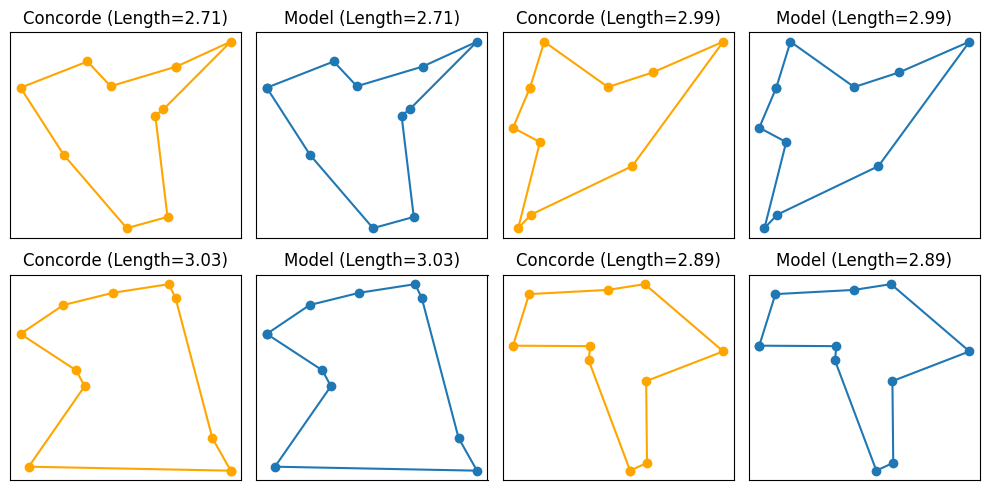

In [17]:
import matplotlib.pyplot as plt

Length_with_NN = compute_tour_length(x_test_tsp, tour_baseline.to('cpu'))

# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

for i in range(2):
    for j in range(2):
        idx = i*2 + j + 1
        points = np.array(x_test_tsp[idx].to('cpu'))

        model_tour = np.array(tour_baseline[idx].to('cpu'))

        # Compute Concorde tour
        concorde_tour = TSPSolver.from_data(points[:, 0], points[:, 1], norm='GEO').solve(verbose=False).tour
        Length_with_concorde = compute_tour_length(torch.tensor(points[None, :]), torch.tensor(concorde_tour[None, :]))

        sequence_points_concorde = points[concorde_tour]
        sequence_points_model = points[model_tour]

        # Connect last point with the first one
        sequence_points_concorde = np.vstack([sequence_points_concorde, sequence_points_concorde[0]])
        sequence_points_model = np.vstack([sequence_points_model, sequence_points_model[0]])

        # Plot Concorde tour
        axs[i, 2*j].plot(sequence_points_concorde[:, 0], sequence_points_concorde[:, 1], marker='o', linestyle='-', color='orange')
        axs[i, 2*j].set_title(f'Concorde (Length={Length_with_concorde.item():.2f})')
        axs[i, 2*j].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

        # Plot Model tour
        axs[i, 2*j + 1].plot(sequence_points_model[:, 0], sequence_points_model[:, 1], marker='o', linestyle='-')
        axs[i, 2*j + 1].set_title(f'Model (Length={Length_with_NN[idx]:.2f})')
        axs[i, 2*j + 1].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

# Adjust layout
plt.tight_layout()
plt.savefig('foo.png')

# Show the plot
plt.show()
